# Importing Relevant Packages

In [1]:
import pandas as pd 
import jax 
from jax.config import config
config.update('jax_enable_x64', True)
import jax.numpy as jnp

import numpy as np
import os as os
import pylab as plt
import h5py # to read hdf5 files
import time
import scipy
from sklearn.model_selection import train_test_split

# Reading in Data 

In [2]:
ratings = pd.read_csv('/Users/joeyt/Desktop/4212 lab/ml-1m/ratings.dat', header = None, sep='::', engine = 'python', encoding='ISO-8859-1')

In [3]:
ratings

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


# Train-Test Split

In [4]:
training_data, testing_data = train_test_split(ratings, test_size=0.1, random_state=1)

In [5]:
training_data.head()
#UserIDs range between 1 and 6040 
#MovieIDs range between 1 and 3952
#Ratings are made on a 5-star scale (whole-star ratings only)
#Timestamp is represented in seconds since the epoch as returned by time(2)
#Each user has at least 20 ratings

,0,1,2,3
316448,1883,2020,3,974876148
82748,549,930,5,976116072
215642,1306,3510,3,1015051441
148022,953,3911,5,975265409
522854,3224,2599,4,968520931


In [6]:
rating_matrix=np.zeros((6040,3952))
for i in range(len(training_data)):
    row = training_data.iloc[i][0]-1
    col = training_data.iloc[i][1]-1
    rating_matrix[row,col] = training_data.iloc[i][2]

In [7]:
testing_matrix=np.zeros((6040,3952))
for i in range(len(testing_data)):
    row = testing_data.iloc[i][0]-1
    col = testing_data.iloc[i][1]-1
    testing_matrix[row,col] = testing_data.iloc[i][2]

# List of Indices for Observed Entries

## Full Train Set

In [8]:
user_train_list = np.array(training_data.loc[:,0])-1
film_train_list = np.array(training_data.loc[:,1])-1

## Full Test Set

In [9]:
user_test_list = np.array(testing_data.loc[:,0])-1
film_test_list = np.array(testing_data.loc[:,1])-1

# Validation Set (Split from Full Train Set)

In [10]:
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=1)

In [11]:
train_data.head()

,0,1,2,3
646371,3891,2858,4,965798840
168205,1069,1437,3,974943407
502265,3082,2762,5,969816764
611075,3705,1303,4,966284955
877959,5306,3033,1,960940239


In [12]:
train_matrix=np.zeros((6040,3952))
for i in range(len(train_data)):
    row = train_data.iloc[i][0]-1
    col = train_data.iloc[i][1]-1
    train_matrix[row,col] = train_data.iloc[i][2]

In [13]:
val_matrix=np.zeros((6040,3952))
for i in range(len(val_data)):
    row = val_data.iloc[i][0]-1
    col = val_data.iloc[i][1]-1
    val_matrix[row,col] = val_data.iloc[i][2]

# List of Indices for Observed Entries

## Partial Train Set

In [14]:
u_list = np.array(train_data.loc[:,0])-1
v_list = np.array(train_data.loc[:,1])-1

## Validation Set 

In [15]:
u_t_list = np.array(val_data.loc[:,0])-1
v_t_list = np.array(val_data.loc[:,1])-1

# General Functions Required

In [16]:
@jax.jit
def extract_film_and_user(param):
    film = param[:(film_dimx*film_dimy)]
    user = param[(film_dimx*film_dimy):]
    return film, user

In [17]:
#for CV
def train_MSE(R,A):
    error=(A-R)[u_list.astype(int), v_list.astype(int)] #only have a subset of info
    return jnp.mean(error**2)
def val_RMSE(R,A):
    error=(A-R)[u_t_list.astype(int), v_t_list.astype(int)] #only have a subset of info
    return jnp.sqrt(jnp.mean(error**2))

# Non-Negative Matrix Factorization

## Functions Required

In [18]:
def make_positive(x):
    return jnp.log(1. + jnp.exp(x))

In [19]:
@jax.jit
def loss_NMF_cv(param):
    film_, user_ = extract_film_and_user(param)


    film = make_positive(film_).reshape(i,df)
    user = make_positive(user_).reshape(du,i)

    rating_matrix_reconstructed = user @ film

    return train_MSE(rating_matrix_reconstructed,train_matrix)
loss_NMF_grad_cv = jax.jit(jax.grad(loss_NMF_cv))

In [20]:
def loss_NMF_grad_wrapper_cv(param):
    return np.array(loss_NMF_grad_cv(param))

In [21]:
def save_traj_cv(param):
    
    global iteration_index
    iteration_index += 1
    current_loss = loss_NMF_cv(param)

  
    if iteration_index % 10 == 0:
        print(f"iteration:{iteration_index} \t \t loss={current_loss:5.5}")


## Cross Validation to find optimal k

In [22]:
du,df=train_matrix.shape
val_error={}

for i in range(1,20):
    iteration_index = 0
    
    np.random.seed(1)
    film_ = np.random.normal(0,1, size=(i,df)) #each col represent i parameters of each film 
    user_ = np.random.normal(0,1, size=(du,i)) #each row represent i parameters of each user

    # make them positives
    film = make_positive(film_)
    user = make_positive(user_)

    # get the dimensions
    film_dimx, film_dimy = film.shape
    user_dimx, user_dimy = user.shape
    param_dim = film_dimx*film_dimy + user_dimx*user_dimy

    # generate a random initial parameter
    param_init = np.random.normal(0,1,size=param_dim)
    
    traj = scipy.optimize.minimize(fun = loss_NMF_cv, #function to minimize
                                    x0 = param_init, #initial guess
                                    method='L-BFGS-B',  #we want to use L-BFGS
                                    jac=loss_NMF_grad_wrapper_cv, #function that computes the gradient
                                    callback=save_traj_cv, #a function used to save some results for later plotting
                                    tol=10**-10,
                                    options={"maxiter":200})  #maximum number of iteration
    #extract final parameter found by LBFGS
    final_param =traj["x"]
    film_, user_ = extract_film_and_user(final_param)

    # make it positive by applying the function log(1+exp(x))
    film = make_positive(film_).reshape(i,df)
    user = make_positive(user_).reshape(du,i)
    val_error[i]=val_RMSE(user@film,val_matrix)
    print(f"R:{i} \t \t val_RMSE={val_RMSE(user@film,val_matrix):5.5}")

iteration:10 	 	 loss=1.5589
iteration:20 	 	 loss=0.96893
iteration:30 	 	 loss=0.86095
iteration:40 	 	 loss=0.83301
iteration:50 	 	 loss=0.82327
iteration:60 	 	 loss=0.81929
iteration:70 	 	 loss=0.81718
iteration:80 	 	 loss=0.81567
iteration:90 	 	 loss=0.81475
iteration:100 	 	 loss=0.81418
iteration:110 	 	 loss=0.81379
iteration:120 	 	 loss=0.81353
iteration:130 	 	 loss=0.81333
iteration:140 	 	 loss=0.81321
iteration:150 	 	 loss=0.8131
iteration:160 	 	 loss=0.81301
iteration:170 	 	 loss=0.81293
iteration:180 	 	 loss=0.81285
iteration:190 	 	 loss=0.81278
iteration:200 	 	 loss=0.81274
R:1 	 	 val_RMSE=0.90992
iteration:10 	 	 loss=1.1907
iteration:20 	 	 loss=0.87687
iteration:30 	 	 loss=0.83117
iteration:40 	 	 loss=0.81706
iteration:50 	 	 loss=0.8085
iteration:60 	 	 loss=0.79533
iteration:70 	 	 loss=0.77925
iteration:80 	 	 loss=0.76686
iteration:90 	 	 loss=0.75872
iteration:100 	 	 loss=0.75302
iteration:110 	 	 loss=0.74953
iteration:120 	 	 loss=0.74719
itera

R:13 	 	 val_RMSE=0.90614
iteration:10 	 	 loss=1.133
iteration:20 	 	 loss=0.85556
iteration:30 	 	 loss=0.80586
iteration:40 	 	 loss=0.77378
iteration:50 	 	 loss=0.72946
iteration:60 	 	 loss=0.69129
iteration:70 	 	 loss=0.6615
iteration:80 	 	 loss=0.63707
iteration:90 	 	 loss=0.61803
iteration:100 	 	 loss=0.60421
iteration:110 	 	 loss=0.59288
iteration:120 	 	 loss=0.58403
iteration:130 	 	 loss=0.57639
iteration:140 	 	 loss=0.57044
iteration:150 	 	 loss=0.56495
iteration:160 	 	 loss=0.5608
iteration:170 	 	 loss=0.55678
iteration:180 	 	 loss=0.55361
iteration:190 	 	 loss=0.55076
iteration:200 	 	 loss=0.54828
R:14 	 	 val_RMSE=0.90926
iteration:10 	 	 loss=  1.2
iteration:20 	 	 loss=0.86927
iteration:30 	 	 loss=0.80608
iteration:40 	 	 loss=0.77231
iteration:50 	 	 loss=0.73171
iteration:60 	 	 loss=0.69127
iteration:70 	 	 loss=0.66013
iteration:80 	 	 loss=0.63476
iteration:90 	 	 loss=0.61608
iteration:100 	 	 loss=0.60038
iteration:110 	 	 loss=0.58852
iteration:1

### Plot Validation RMSE against k

In [23]:
val_rmse=pd.DataFrame(val_error.values(),index=val_error.keys()) 

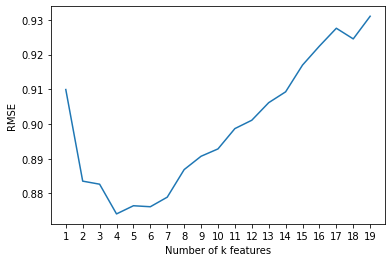

In [24]:
plt.plot(val_rmse[0])
plt.xticks(val_rmse.index)
plt.xlabel("Number of k features")
plt.ylabel("RMSE")
plt.show()

## Using k=4 for Our Final Model

In [25]:
nu,nf=rating_matrix.shape
R = 4 #number of features k
np.random.seed(1)
film_ = np.random.normal(0,1, size=(R,nf)) #each col represent 4 parameters of each film 
user_ = np.random.normal(0,1, size=(nu,R)) #each row represent 4 parameters of each user

film = make_positive(film_)
user = make_positive(user_)

film_dimx, film_dimy = film.shape
user_dimx, user_dimy = user.shape

param_dim = film_dimx*film_dimy + user_dimx*user_dimy

param_init = np.random.normal(0,1,size=param_dim)

@jax.jit
def extract_film_and_user(param):
    film = param[:(film_dimx*film_dimy)]
    user = param[(film_dimx*film_dimy):]
    return film, user

def MSE(R,A):
    error=(A-R)[user_train_list.astype(int), film_train_list.astype(int)] #only have a subset of info
    return jnp.mean(error**2)

@jax.jit
def loss_NMF(param):
    film_, user_ = extract_film_and_user(param)
    
    film = make_positive(film_).reshape(R,nf)
    user = make_positive(user_).reshape(nu,R)
    
    rating_matrix_reconstructed = user @ film
    
    return MSE(rating_matrix_reconstructed,rating_matrix) #for entire train set
    

loss_NMF_grad = jax.jit(jax.grad(loss_NMF))

def loss_NMF_grad_wrapper(param):
    return np.array(loss_NMF_grad(param))



In [26]:
loss_history = []  #to save the loss trajectory
time_history = []  #to save the compute time
iteration_index = 0

def save_traj(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_NMF(param)

    # display the loss every 10 iterations
    if iteration_index % 10 == 0:
        print(f"iteration:{iteration_index} \t \t loss={current_loss:5.5}")
    
    # record everything
    loss_history.append(jnp.sqrt(current_loss))
    time_history.append(time.time() - start)

start = time.time()
traj = scipy.optimize.minimize(fun = loss_NMF, #function to minimize
                                x0 = param_init, #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=loss_NMF_grad_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later plotting
                                tol=10**-10,
                                options={"maxiter":200})  #maximum number of iteration

iteration:10 	 	 loss=1.0087
iteration:20 	 	 loss=0.85032
iteration:30 	 	 loss=0.82075
iteration:40 	 	 loss=0.80726
iteration:50 	 	 loss=0.78974
iteration:60 	 	 loss=0.76792
iteration:70 	 	 loss=0.75325
iteration:80 	 	 loss=0.74061
iteration:90 	 	 loss=0.7311
iteration:100 	 	 loss=0.72288
iteration:110 	 	 loss=0.71627
iteration:120 	 	 loss=0.70999
iteration:130 	 	 loss=0.70482
iteration:140 	 	 loss=0.70045
iteration:150 	 	 loss=0.69669
iteration:160 	 	 loss=0.69383
iteration:170 	 	 loss=0.69151
iteration:180 	 	 loss=0.68956
iteration:190 	 	 loss=0.68799
iteration:200 	 	 loss=0.68677


### Plot Loss History against Time History

Text(0, 0.5, 'RMSE reconstruction')

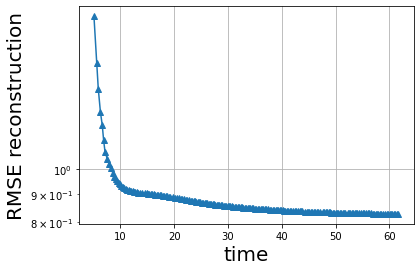

In [27]:
plt.plot(time_history, loss_history, "-^")
plt.yscale("log")
plt.grid(True)
plt.xlabel("time", fontsize=20)
plt.ylabel("RMSE reconstruction", fontsize=20)


### Calculate Test RMSE

In [28]:
#extract final parameter found by LBFGS
final_param =traj["x"]
film_, user_ = extract_film_and_user(final_param)

# make it positive by applying the function log(1+exp(x))
film = make_positive(film_).reshape(R,nf)
user = make_positive(user_).reshape(nu,R)

def test_RMSE(R,A):
    error=(A-R)[user_test_list.astype(int), film_test_list.astype(int)] #only have a subset of info
    return jnp.sqrt(jnp.mean(error**2))

test_RMSE(user@film,testing_matrix)

DeviceArray(0.87253575, dtype=float64)

# Probabilistic Matrix Factorization L-BFGS

## Functions Required

In [34]:
@jax.jit
def loss_PMF_cv(param):
    
    films_,users_ = extract_film_and_user(param)
    
    users = users_.reshape(du,i)
    films = films_.reshape(i,df)
    
    predicted = users @ films
    error=(predicted-train_matrix)[u_list.astype(int), v_list.astype(int)]
    error_sq=error**2
    
    return 0.5*(jnp.sum(error_sq)+j*jnp.sum(users@users.T)+k*jnp.sum(films@films.T))
    

# automatic differentiation magic here!
loss_PMF_grad_cv = jax.jit(jax.grad(loss_PMF_cv))

#let's create a wrapper to make sure the output is a standard numpy gradient
def loss_PMF_grad_wrapper_cv(param):
    return np.array(loss_PMF_grad_cv(param))

In [35]:
def save_traj_cv_pmf(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_PMF_cv(param)

    # display the loss every 100 iterations
    if iteration_index % 100 == 0:
        print(f"iteration:{iteration_index} \t \t loss={current_loss:5.5}")

## Cross Validation to find optimal k with $\lambda{u} = 0.01$ $\lambda{v} = 0.01$

In [36]:
val_error_pmf={}
du,df=train_matrix.shape
j=0.01
k=0.01
for i in range(1,11):

    iteration_index=0

    R=i #number of features k 
    np.random.seed(1)

    film_ = np.random.normal(0,1, size=(i,df)) 
    user_ = np.random.normal(0,1, size=(du,i))
    film_dimx, film_dimy = film_.shape
    user_dimx, user_dimy = user_.shape

    param_dim = film_dimx*film_dimy + user_dimx*user_dimy

    # generate a random initial parameter
    param_init = np.random.normal(0,1,size=param_dim)

    traj = scipy.optimize.minimize(fun = loss_PMF_cv, #function to minimize
                                    x0 = param_init, #initial guess
                                    method='L-BFGS-B',  #we want to use L-BFGS
                                    jac=loss_PMF_grad_wrapper_cv, #function that computes the gradient
                                    callback=save_traj_cv_pmf, #a function used to save some results for later plotting
                                    tol=10**-10,
                                    options={"maxiter":200})  #maximum number of iteration
    final_param =traj["x"]
    film_, user_ = extract_film_and_user(final_param)

    film = film_.reshape(i,df)
    user = user_.reshape(du,i)

    val_error_pmf[i]=val_RMSE(user@film,val_matrix)
    print(f"R:{i} \t \t val_RMSE={val_RMSE(user@film,val_matrix):5.5}")

iteration:100 	 	 loss=3.2552e+05
iteration:200 	 	 loss=3.2151e+05
R:1 	 	 val_RMSE=0.93601
iteration:100 	 	 loss=3.1759e+05
iteration:200 	 	 loss=2.9644e+05
R:2 	 	 val_RMSE=0.90339
iteration:100 	 	 loss=3.0323e+05
iteration:200 	 	 loss=2.8385e+05
R:3 	 	 val_RMSE=0.89603
iteration:100 	 	 loss=2.9682e+05
iteration:200 	 	 loss=2.7511e+05
R:4 	 	 val_RMSE=0.89507
iteration:100 	 	 loss=2.8668e+05
iteration:200 	 	 loss=2.6439e+05
R:5 	 	 val_RMSE=0.89485
iteration:100 	 	 loss=2.8512e+05
iteration:200 	 	 loss=2.5898e+05
R:6 	 	 val_RMSE=0.90094
iteration:100 	 	 loss=2.8029e+05
iteration:200 	 	 loss=2.562e+05
R:7 	 	 val_RMSE=0.90356
iteration:100 	 	 loss=2.7694e+05
iteration:200 	 	 loss=2.5265e+05
R:8 	 	 val_RMSE=0.91656
iteration:100 	 	 loss=2.7641e+05
iteration:200 	 	 loss=2.4804e+05
R:9 	 	 val_RMSE=0.92173
iteration:100 	 	 loss=2.7694e+05
iteration:200 	 	 loss=2.483e+05
R:10 	 	 val_RMSE=0.93188


### Plot Validation RMSE against k

In [37]:
val_rmse_pmf=pd.DataFrame(val_error_pmf.values(),index=val_error_pmf.keys()) 

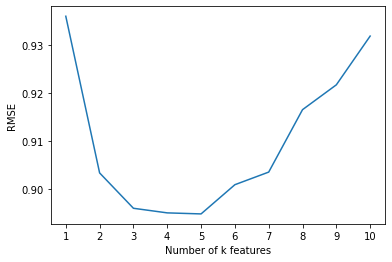

In [38]:
plt.plot(val_rmse_pmf[0])
plt.xticks(val_rmse_pmf.index)
plt.xlabel("Number of k features")
plt.ylabel("RMSE")
plt.show()

## Cross Validation to find optimal k with $\lambda{u} = 0.001$ $\lambda{v} = 0.001$

In [39]:
@jax.jit
def loss_PMF_cv(param):
    
    films_,users_ = extract_film_and_user(param)
    
    users = users_.reshape(du,i)
    films = films_.reshape(i,df)
    
    predicted = users @ films
    error=(predicted-train_matrix)[u_list.astype(int), v_list.astype(int)]
    error_sq=error**2
    
    return 0.5*(jnp.sum(error_sq)+j*jnp.sum(users@users.T)+k*jnp.sum(films@films.T))


# automatic differentiation magic here!
loss_PMF_grad_cv = jax.jit(jax.grad(loss_PMF_cv))

#let's create a wrapper to make sure the output is a standard numpy gradient
def loss_PMF_grad_wrapper_cv(param):
    return np.array(loss_PMF_grad_cv(param))

In [40]:
def save_traj_cv_pmf(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_PMF_cv(param)

    # display the loss every 100 iterations
    if iteration_index % 100 == 0:
        print(f"iteration:{iteration_index} \t \t loss={current_loss:5.5}")

In [41]:
val_error_pmf1={}
du,df=train_matrix.shape
j=0.001
k=0.001
for i in range(1,11):

    iteration_index=0

    R=i #number of features k 
    np.random.seed(1)

    film_ = np.random.normal(0,1, size=(i,df)) 
    user_ = np.random.normal(0,1, size=(du,i))
    film_dimx, film_dimy = film_.shape
    user_dimx, user_dimy = user_.shape

    param_dim = film_dimx*film_dimy + user_dimx*user_dimy

    # generate a random initial parameter
    param_init = np.random.normal(0,1,size=param_dim)

    traj = scipy.optimize.minimize(fun = loss_PMF_cv, #function to minimize
                                    x0 = param_init, #initial guess
                                    method='L-BFGS-B',  #we want to use L-BFGS
                                    jac=loss_PMF_grad_wrapper_cv, #function that computes the gradient
                                    callback=save_traj_cv_pmf, #a function used to save some results for later plotting
                                    tol=10**-10,
                                    options={"maxiter":200})  #maximum number of iteration
    final_param =traj["x"]
    film_, user_ = extract_film_and_user(final_param)

    film = film_.reshape(i,df)
    user = user_.reshape(du,i)

    val_error_pmf1[i]=val_RMSE(user@film,val_matrix)
    print(f"R:{i} \t \t val_RMSE={val_RMSE(user@film,val_matrix):5.5}")

iteration:100 	 	 loss=3.0458e+05
iteration:200 	 	 loss=2.9907e+05
R:1 	 	 val_RMSE=0.9174
iteration:100 	 	 loss=2.8329e+05
iteration:200 	 	 loss=2.7545e+05
R:2 	 	 val_RMSE=0.88589
iteration:100 	 	 loss=2.7079e+05
iteration:200 	 	 loss=2.6305e+05
R:3 	 	 val_RMSE=0.88459
iteration:100 	 	 loss=2.6323e+05
iteration:200 	 	 loss=2.5249e+05
R:4 	 	 val_RMSE=0.88186
iteration:100 	 	 loss=2.5502e+05
iteration:200 	 	 loss=2.4372e+05
R:5 	 	 val_RMSE=0.88304
iteration:100 	 	 loss=2.4931e+05
iteration:200 	 	 loss=2.3541e+05
R:6 	 	 val_RMSE=0.88663
iteration:100 	 	 loss=2.4498e+05
iteration:200 	 	 loss=2.304e+05
R:7 	 	 val_RMSE=0.8949
iteration:100 	 	 loss=2.4082e+05
iteration:200 	 	 loss=2.2413e+05
R:8 	 	 val_RMSE=0.90636
iteration:100 	 	 loss=2.3815e+05
iteration:200 	 	 loss=2.2059e+05
R:9 	 	 val_RMSE=0.91304
iteration:100 	 	 loss=2.3661e+05
iteration:200 	 	 loss=2.1763e+05
R:10 	 	 val_RMSE=0.92554


### Plot Validation RMSE against k

In [42]:
val_rmse_pmf1=pd.DataFrame(val_error_pmf1.values(),index=val_error_pmf1.keys()) 

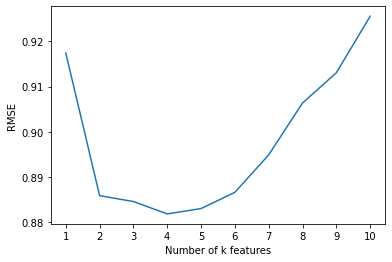

In [43]:
plt.plot(val_rmse_pmf1[0])
plt.xticks(val_rmse_pmf1.index)
plt.xlabel("Number of k features")
plt.ylabel("RMSE")
plt.show()

## Cross Validation to find optimal k with $\lambda{u} = 0.0001$ $\lambda{v} = 0.0001$

In [44]:
@jax.jit
def loss_PMF_cv(param):
    
    films_,users_ = extract_film_and_user(param)
    
    users = users_.reshape(du,i)
    films = films_.reshape(i,df)
    
    predicted = users @ films
    error=(predicted-train_matrix)[u_list.astype(int), v_list.astype(int)]
    error_sq=error**2
    
    return 0.5*(jnp.sum(error_sq)+j*jnp.sum(users@users.T)+k*jnp.sum(films@films.T))


# automatic differentiation magic here!
loss_PMF_grad_cv = jax.jit(jax.grad(loss_PMF_cv))

#let's create a wrapper to make sure the output is a standard numpy gradient
def loss_PMF_grad_wrapper_cv(param):
    return np.array(loss_PMF_grad_cv(param))

In [45]:
def save_traj_cv_pmf(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_PMF_cv(param)

    if iteration_index % 100 == 0:
        print(f"iteration:{iteration_index} \t \t loss={current_loss:5.5}")

In [46]:
val_error_pmf2={}
du,df=train_matrix.shape
j=0.0001
k=0.0001
for i in range(1,11):

    iteration_index=0

    R=i #number of features k
    np.random.seed(1)

    film_ = np.random.normal(0,1, size=(i,df)) 
    user_ = np.random.normal(0,1, size=(du,i))
    film_dimx, film_dimy = film_.shape
    user_dimx, user_dimy = user_.shape

    param_dim = film_dimx*film_dimy + user_dimx*user_dimy

    # generate a random initial parameter
    param_init = np.random.normal(0,1,size=param_dim)

    traj = scipy.optimize.minimize(fun = loss_PMF_cv, #function to minimize
                                    x0 = param_init, #initial guess
                                    method='L-BFGS-B',  #we want to use L-BFGS
                                    jac=loss_PMF_grad_wrapper_cv, #function that computes the gradient
                                    callback=save_traj_cv_pmf, #a function used to save some results for later plotting
                                    tol=10**-10,
                                    options={"maxiter":200})  #maximum number of iteration
    final_param =traj["x"]
    film_, user_ = extract_film_and_user(final_param)

    film = film_.reshape(i,df)
    user = user_.reshape(du,i)

    val_error_pmf2[i]=val_RMSE(user@film,val_matrix)
    print(f"R:{i} \t \t val_RMSE={val_RMSE(user@film,val_matrix):5.5}")

iteration:100 	 	 loss=2.9594e+05
iteration:200 	 	 loss=2.9443e+05
R:1 	 	 val_RMSE=0.91101
iteration:100 	 	 loss=2.723e+05
iteration:200 	 	 loss=2.6909e+05
R:2 	 	 val_RMSE=0.88444
iteration:100 	 	 loss=2.6006e+05
iteration:200 	 	 loss=2.5682e+05
R:3 	 	 val_RMSE=0.88442
iteration:100 	 	 loss=2.507e+05
iteration:200 	 	 loss=2.4497e+05
R:4 	 	 val_RMSE=0.88037
iteration:100 	 	 loss=2.4257e+05
iteration:200 	 	 loss=2.3598e+05
R:5 	 	 val_RMSE=0.88394
iteration:100 	 	 loss=2.3611e+05
iteration:200 	 	 loss=2.2712e+05
R:6 	 	 val_RMSE=0.88815
iteration:100 	 	 loss=2.3074e+05
iteration:200 	 	 loss=2.2069e+05
R:7 	 	 val_RMSE=0.89524
iteration:100 	 	 loss=2.2555e+05
iteration:200 	 	 loss=2.1416e+05
R:8 	 	 val_RMSE=0.90487
iteration:100 	 	 loss=2.2166e+05
iteration:200 	 	 loss=2.0855e+05
R:9 	 	 val_RMSE=0.92007
iteration:100 	 	 loss=2.1988e+05
iteration:200 	 	 loss=2.0513e+05
R:10 	 	 val_RMSE=0.93279


### Plot Validation RMSE against k 

In [47]:
val_rmse_pmf2=pd.DataFrame(val_error_pmf2.values(),index=val_error_pmf2.keys()) 

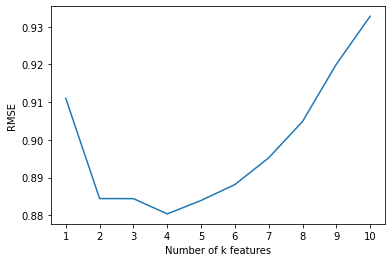

In [48]:
plt.plot(val_rmse_pmf2[0])
plt.xticks(val_rmse_pmf2.index)
plt.xlabel("Number of k features")
plt.ylabel("RMSE")
plt.show()

## Summary of CV

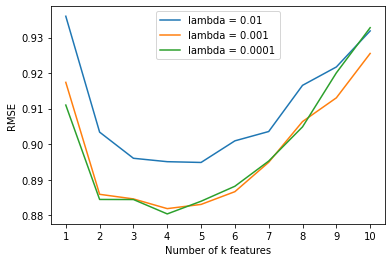

In [49]:
plt.plot(val_rmse_pmf[0],label="lambda = 0.01")
plt.plot(val_rmse_pmf1[0],label = "lambda = 0.001 ")
plt.plot(val_rmse_pmf2[0],label = "lambda = 0.0001")
plt.xticks(val_rmse_pmf.index)
plt.xlabel("Number of k features")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## Using k=4 $\lambda{u}$ = 0.0001 and $\lambda{v}$ = 0.0001 for Our Final Model 

In [50]:
nu,nf=rating_matrix.shape
R=4 #number of features k 
j=0.0001
k=0.0001

np.random.seed(1)

film_ = np.random.normal(0,1, size=(R,nf)) 
user_ = np.random.normal(0,1, size=(nu,R))
film_dimx, film_dimy = film_.shape
user_dimx, user_dimy = user_.shape

param_dim = film_dimx*film_dimy + user_dimx*user_dimy

# generate a random initial parameter
param_init = np.random.normal(0,1,size=param_dim)

@jax.jit
def extract_film_and_user(param):
    film = param[:(film_dimx*film_dimy)]
    user = param[(film_dimx*film_dimy):]
    return film, user

@jax.jit
def loss_PMF(param):
    
    films_,users_ = extract_film_and_user(param)
    films = films_.reshape(R,nf)
    users = users_.reshape(nu,R)
    
    predicted = users @ films
    error=(predicted-rating_matrix)[user_train_list.astype(int),film_train_list.astype(int)]
    error_sq=error**2
    
    
    return 0.5*(jnp.sum(error_sq)+j*jnp.sum(users@users.T)+k*jnp.sum(films@films.T))
    

# automatic differentiation magic here!
loss_PMF_grad = jax.jit(jax.grad(loss_PMF))

#let's create a wrapper to make sure the output is a standard numpy gradient
def loss_PMF_grad_wrapper(param):
    return np.array(loss_PMF_grad(param))



In [51]:
loss_history = []  #to save the loss trajectory
time_history = []  #to save the compute time
iteration_index = 0

def save_traj_pmf(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_PMF(param)

    # display the loss every 100 iterations
    if iteration_index % 100 == 0:
        print(f"iteration:{iteration_index} \t \t loss={current_loss:5.5}")
    
    # record everything
    loss_history.append(current_loss)
    time_history.append(time.time() - start)

start = time.time()
traj = scipy.optimize.minimize(fun = loss_PMF, #function to minimize
                                x0 = param_init, #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=loss_PMF_grad_wrapper, #function that computes the gradient
                                callback=save_traj_pmf, #a function used to save some results for later plotting
                                tol=10**-10,
                                options={"maxiter":200})  #maximum number of iteration

iteration:100 	 	 loss=3.1522e+05
iteration:200 	 	 loss=3.0878e+05


### Plot Loss History against Time History

Text(0, 0.5, 'Loss History reconstruction')

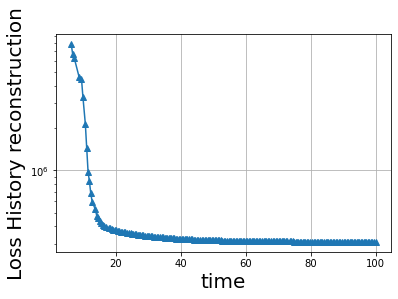

In [52]:
plt.plot(time_history, loss_history, "-^")
plt.yscale("log")
plt.grid(True)
plt.xlabel("time", fontsize=20)
plt.ylabel("Loss History reconstruction", fontsize=20)

### Calculate Test RMSE

In [53]:
#extract final parameter found by LBFGS
final_param =traj["x"]
film_, user_ = extract_film_and_user(final_param)

film = film_.reshape(R,nf)
user = user_.reshape(nu,R)

def test_RMSE(R,A):
    error=(A-R)[user_test_list.astype(int), film_test_list.astype(int)] #only have a subset of info
    return jnp.sqrt(jnp.mean(error**2))

test_RMSE(user@film,testing_matrix)

DeviceArray(0.87665551, dtype=float64)

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00,
        4.000e+00, 1.000e+01, 2.000e+00, 6.000e+00, 1.500e+01, 1.800e+01,
        2.200e+01, 3.600e+01, 4.400e+01, 6.500e+01, 7.300e+01, 1.060e+02,
        1.520e+02, 2.050e+02, 2.920e+02, 3.480e+02, 4.300e+02, 5.680e+02,
        7.320e+02, 8.480e+02, 1.048e+03, 1.307e+03, 1.489e+03, 1.791e+03,
        2.263e+03, 2.571e+03, 3.135e+03, 3.572e+03, 4.082e+03, 4.803e+03,
        5.391e+03, 5.976e+03, 6.221e+03, 6.612e+03, 6.831e+03, 6.525e+03,
        6.467e+03, 5.770e+03, 5.155e+03, 4.176e+03, 3.408e+03, 2.599e+03,
        1.858e+03, 1.258e+03, 7.530e+0

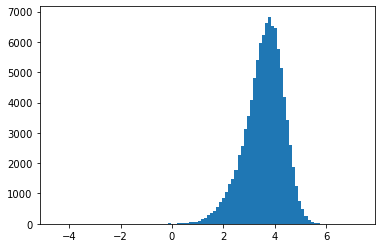

In [54]:
plt.hist( (user @ film)[user_test_list.astype(int), film_test_list.astype(int)], bins=100)

In [55]:
jnp.save("rating_prediction_PMF_LBFGS",user@film)

In [56]:
rating_pred=np.load("rating_prediction_PMF_LBFGS.npy")

In [57]:
for i in range(0,len(rating_pred)):
    for j in range(0,len(rating_pred[0])):
        if rating_pred[i][j]>5:
            rating_pred[i][j]=5
        elif rating_pred[i][j]<1:
            rating_pred[i][j]=1
        else:
            rating_pred[i][j]=rating_pred[i][j]

In [58]:
test_RMSE(rating_pred,testing_matrix)

DeviceArray(0.87345923, dtype=float64)